In [1]:
%load_ext autoreload
%autoreload 1
%aimport pygenesig.file_formats
%aimport pygenesig.visualization

from pygenesig.file_formats import *
from pygenesig.bioqc import BioQCSignatureTester
from pygenesig.tools import *
from pygenesig.visualization import * 

from pylab import * 
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Run GTEx v6 signatures on mouseGNF samples

In [2]:
gtex_sig = load_gmt("../results/gtex_v6_gini_0.8_3/signatures.gmt")

In [3]:
for l in gtex_sig:
    print(l)

Adipose_Visceral_Omentum
Uterus
Brain_Anterior_cingulate_cortex_BA24
Spleen
Colon_Sigmoid
Artery_Tibial
Nerve_Tibial
Brain_Frontal_Cortex_BA9
Skin_Sun_Exposed_Lower_leg
Cells_Transformed_fibroblasts
Adrenal_Gland
Vagina
Brain_Spinal_cord_cervical_c-1
Esophagus_Muscularis
Pituitary
Brain_Amygdala
Cells_EBV-transformed_lymphocytes
Small_Intestine_Terminal_Ileum
Brain_Cerebellar_Hemisphere
Breast_Mammary_Tissue
Kidney_Cortex
Adipose_Subcutaneous
Thyroid
Stomach
Brain_Caudate_basal_ganglia
Bladder
Skin_Not_Sun_Exposed_Suprapubic
Colon_Transverse
Brain_Nucleus_accumbens_basal_ganglia
Esophagus_Mucosa
Pancreas
Brain_Putamen_basal_ganglia
Esophagus_Gastroesophageal_Junction
Brain_Hypothalamus
Muscle_Skeletal
Heart_Atrial_Appendage
Liver
Lung
Artery_Aorta
Brain_Cortex
Minor_Salivary_Gland
Heart_Left_Ventricle
Whole_Blood
Brain_Substantia_nigra
Prostate
Brain_Cerebellum
Artery_Coronary
Brain_Hippocampus
Ovary
Testis


## load mouseGNF data

In [4]:
m_expr = read_expr("../data_processed/mouseGNF/exprs.npy")
m_rosetta_inv = read_rosetta("../data_processed/mouseGNF/rosetta.csv", inverse=True)
m_target = read_target("../data_processed/mouseGNF/target.csv")

In [5]:
m_expr.shape, m_target.shape

((15851, 160), (160,))

### Translate the signature names from mouseGNF 
For a better overview in the heatmap, we map the names from the mouseGNF dataset to the equivalent names
in the gtex signatures. This was done manually in an excel sheet.
* Tissue names are mapped to an equivalent name
* Tissues/Cell types which do not appear in the GTEx signatures are excluded. 

In [6]:
m_target_map = pd.read_csv("../manual_annotation/mouseGNF_map_tissues.csv", sep=";", header=None)

In [7]:
target_dict = dict(zip(m_target_map[0], m_target_map[1]))

In [8]:
m_target_new = pd.Series([target_dict[t] for t in m_target])

In [9]:
m_expr_new = m_expr[:, ~m_target_new.isnull().values]
m_target_new = m_target_new[~m_target_new.isnull()].values

In [10]:
m_expr_new.shape, m_target_new.shape

((15851, 60), (60,))

### Translate signatures to index of gene expression matrix
We need to transform the gene symbols in the gtex-signatures to
the indices of the gene expression matrix of mouseGNF

In [11]:
gtex_sig_ind = translate_signatures(gtex_sig, m_rosetta_inv, ignore_missing=True)

## run BioQC

In [12]:
st = BioQCSignatureTester(m_expr_new, m_target_new)

In [13]:
scores = st.score_signatures(gtex_sig_ind)

### Visualize the score matrix
Clustermap of the BioQC-scores. BioQC scores exceeding 10 are clipped. 

In [14]:
score_mat = aggregate_scores(st.sort_signatures(gtex_sig_ind), scores, m_target_new)

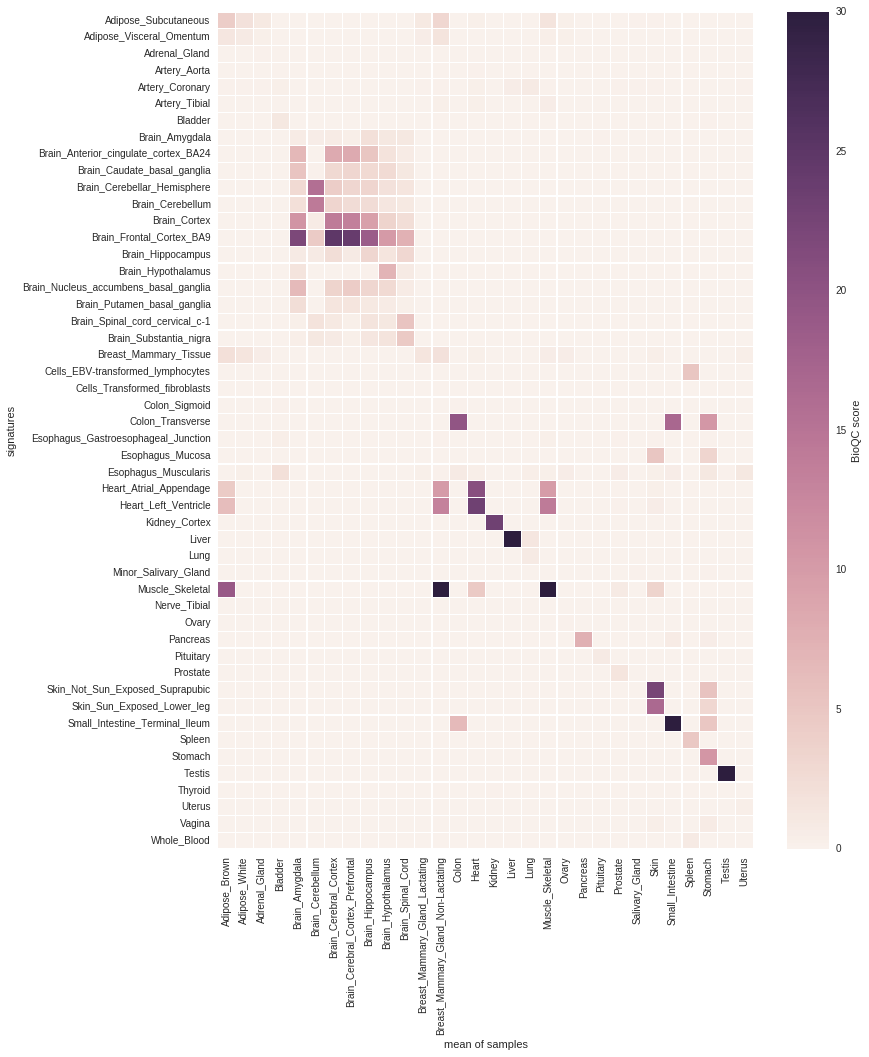

In [15]:
fig, ax = plot_score_heatmap(score_mat)

In [16]:
fig.savefig("../results/figures/gtex_mousegnf_scores.pdf", bbox_inches='tight')

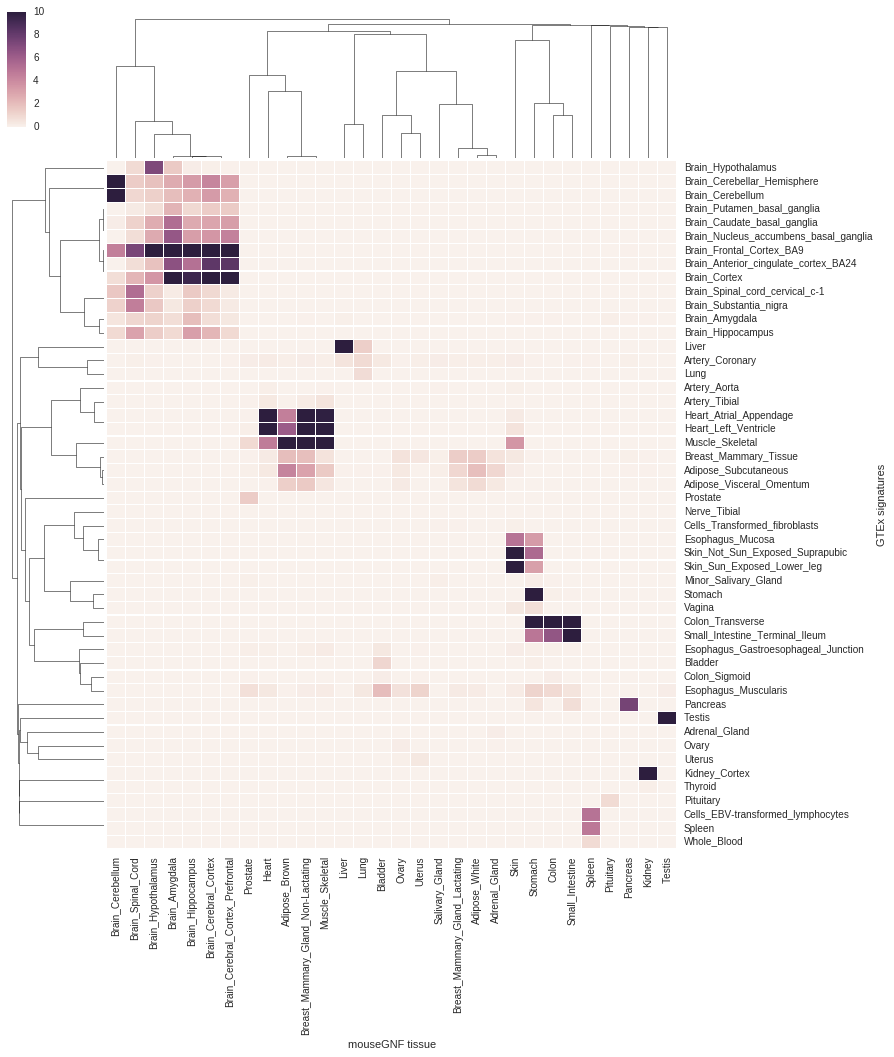

In [17]:
g = sns.clustermap(score_mat, metric='correlation', linewidths=.2, figsize=heatmap_figsize(score_mat.shape[0], score_mat.shape[1]), vmax=10)
ax = g.ax_heatmap
plt.setp(ax.get_yticklabels(), rotation=0);
ax.set_ylabel("GTEx signatures")
ax.set_xlabel("mouseGNF tissue")

In [18]:
g.savefig("../results/figures/gtex_mousegnf_cluster.pdf", bbox_inches='tight')

## Only tissues that appear in both datasets

In [19]:
gtex_map = pd.read_csv("../manual_annotation/gtex_reduced.csv", header=None, sep=";")

In [20]:
target_dict = dict(gtex_map.as_matrix())

In [21]:
gtex_reduced = {
    reduced: set() for original, reduced in target_dict.items() if not str(reduced) == 'nan'
}

In [22]:
for original, reduced in target_dict.items():
    if str(reduced) != 'nan':
        gtex_reduced[reduced] |= set(gtex_sig_ind[original])

In [23]:
mr_target_map = pd.read_csv("../manual_annotation/mouseGNF_map_tissues_reduced.csv", header=None, sep=';')
mr_target_dict = dict(mr_target_map.as_matrix())

In [24]:
mr_target_new = pd.Series([mr_target_dict[t] for t in m_target])
mr_expr_new = m_expr[:, ~mr_target_new.isnull().values]
mr_target_new = mr_target_new[~mr_target_new.isnull()].values

In [25]:
mr_expr_new.shape, mr_target_new.shape

((15851, 60), (60,))

In [26]:
st = BioQCSignatureTester(mr_expr_new, mr_target_new)
scores = st.score_signatures(gtex_reduced)

In [27]:
score_mat = aggregate_scores(st.sort_signatures(gtex_reduced), scores, mr_target_new)

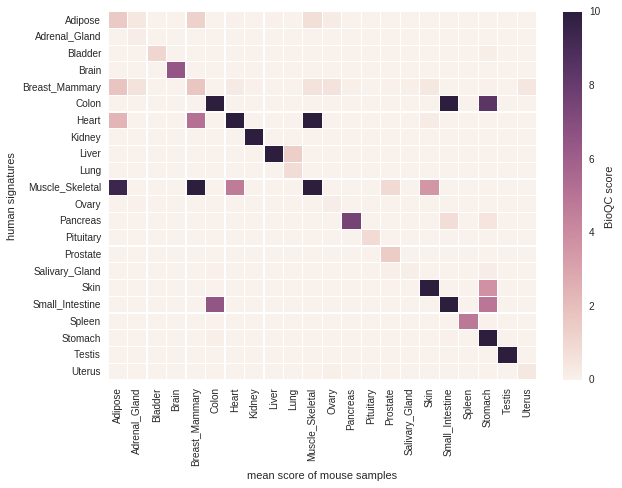

In [28]:
fig, ax = plot_score_heatmap(score_mat, clip=10)
ax.set_ylabel("human signatures")
ax.set_xlabel("mean score of mouse samples")

In [29]:
fig.savefig("../results/figures/gtex_mousegnf_reduced.pdf", bbox_inches='tight')